In [89]:
import torch
from transformers import *

In [198]:
import numpy as np
import pandas as pd

STORY = "pieman"

token_stimulus_df = pd.read_csv("data/stimuli/{}/tr_tokens.csv".format(STORY))
token_stimulus_df.n_tokens = token_stimulus_df.n_tokens.fillna(0)
token_stimulus_df.tokens = token_stimulus_df.tokens.fillna("")

In [199]:
token_stimulus_df.head()

,tr,start_ts,end_ts,tr.1,tokens,n_tokens,tr_shift,prev_tr
0,10,15.089999,16.310000,10,I began my illustrious,4.0,NaN,NaN
1,11,16.330000,17.929999,11,career in journalism,3.0,1.0,10.0
2,12,18.469999,19.390000,12,in the Bronx where,4.0,1.0,11.0
3,13,19.390000,20.890000,13,I toiled as a hard,5.0,1.0,12.0
4,14,20.890000,22.360000,14,boiled reporter for the,4.0,1.0,13.0


### Stimulus Analysis
Quick checks: how many words do we have per TR?  
Use this to determine parameters for attention head analysis.

In [190]:
token_stimulus_df.n_tokens.describe()

count    277.000000
mean       3.454874
std        2.127022
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       12.000000
Name: n_tokens, dtype: float64

In [191]:
token_stimulus_df.n_tokens.value_counts().sort_index()

0.0     23
1.0     23
2.0     48
3.0     59
4.0     44
5.0     41
6.0     18
7.0      4
8.0     12
9.0      4
12.0     1
Name: n_tokens, dtype: int64

# RSMs from BERT

#### Set up BERT model

In [177]:
bert_weights = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights)

# Models can return full list of hidden-states & attentions weights at each layer
bert = BertModel.from_pretrained(bert_weights,
                                 output_hidden_states=True,
                                 output_attentions=True)

In [235]:
def stimulus_to_rsm_dataframe(stimulus, tr_lookback_window):

    # Set this inside the loop based on whichever BERT model we're using
    num_bert_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):

        # Get the whole window we're going to 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        window_tokens = torch.tensor([bert_tokenizer.encode(window_stimulus, add_special_tokens=True)])

        tr_tokens = torch.tensor([bert_tokenizer.encode(tr, add_special_tokens=False)])[0]

        with torch.no_grad():

            tr_activation_array[i] = {}
            bert_states, bert_attentions = bert(window_tokens)[-2:]
            
            num_bert_layers = len(bert_states)

            for l, layer in enumerate(bert_states):
                
                if len(tr_tokens) > 0:
                    # ASSUMPTION: we do not want to include the CLS/SEP token in the TR RSM.
                    # If we do, switch indexing here to include last token.
                    tr_activations = layer[0][-(len(tr_tokens) + 1):-1]
                    
                else:
                    # ASSUMPTION: if we don't have any tokens in this TR, use the last token's representation. --> should we use lasttoken or CLS/SEP?
                    tr_activations = layer[0][-2:-1]

                # ASSUMPTION: take the mean of all tokens falling inside the TR stimuli window.
                print(torch.mean(tr_activations, 0).shape)
                tr_activation_array[i][l] = torch.mean(tr_activations, 0)

    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_bert_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
    
        stacked = np.stack([l.numpy() for l in layer_activations], axis=0)
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked))
        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

## Activation RSMs

Try generating a set of RSMs for a full text.

In [236]:
stimulus_for_rsm = token_stimulus_df

In [237]:
activation_rsm_dfs = stimulus_to_rsm_dataframe(stimulus_for_rsm.tokens.values, 20)

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size

KeyboardInterrupt: 

In [202]:
results_rsm_df = activation_rsm_dfs

In [203]:
for i, df in enumerate(results_rsm_df):
    df.to_pickle("data/{}/{}/layer_{}_rsm.pkl".format(STORY, bert_weights, i))

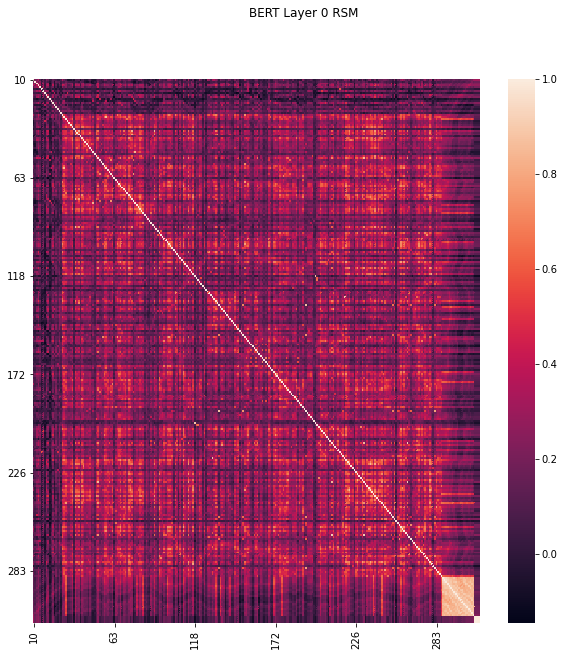

In [204]:
import matplotlib.pylab as plt
import seaborn as sns

plt.figure(figsize=(10,10))
ax = sns.heatmap(results_rsm_df[0], xticklabels=stimulus_for_rsm.tr, yticklabels=stimulus_for_rsm.tr)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])
plt.suptitle("BERT Layer 0 RSM");

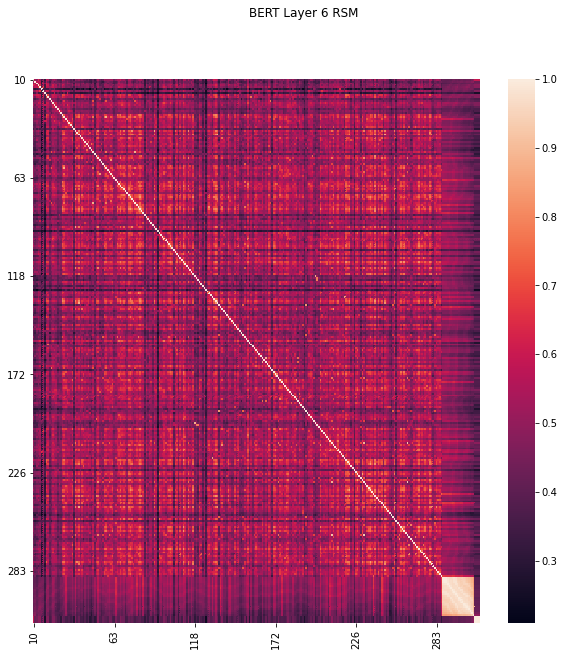

In [205]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(results_rsm_df[5], xticklabels=stimulus_for_rsm.tr, yticklabels=stimulus_for_rsm.tr)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("BERT Layer 6 RSM");

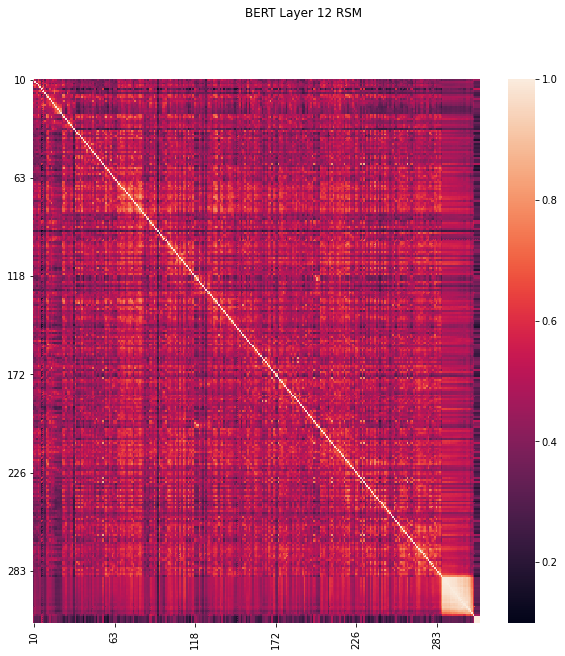

In [206]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(results_rsm_df[-1], xticklabels=stimulus_for_rsm.tr, yticklabels=stimulus_for_rsm.tr)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("BERT Layer 12 RSM");

# Attention RSMs

In [245]:
def stimulus_to_attention_rsm_dataframe(stimulus, tr_lookback_window, num_window_tokens=10, num_tr_tokens=6, verbose=False):
    """Return window_tokens x tr_tokens x num_heads attention matrix"""

    # Set this inside the loop based on whichever BERT model we're using
    num_bert_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):

        # Get all of the stimulus for the TR lookback window (e.g. words for last X seconds) 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        
        # Get the list of BERT tokens involved in that window
        window_tokens = bert_tokenizer.encode_plus(window_stimulus, return_tensors='pt', add_special_tokens=True)
        
        # window_token_ids is now a tensor containing *all* of the tokens in this TR stimulus window.
        # We need to filter it down to our fixed dimensionality, window_tokens
        window_token_ids = window_tokens['input_ids']
    
        if len(window_token_ids[0]) < num_window_tokens:
            # We don't have enough words yet. This is typical for the first few TRs-- we need to build up context.
            if verbose:
                print("TR {}: not enough tokens ({}/{})".format(i, len(window_token_ids[0]), num_window_tokens))
            continue

        truncated_window_token_ids = window_token_ids[0][-num_window_tokens:]
        if verbose:
            print("TR {}: more than enough tokens ({}/{}), trimmed to {}.".format(i, len(window_token_ids[0]), num_window_tokens, len(truncated_window_token_ids)))
    
        with torch.no_grad():

            tr_activation_array[i] = {}
            _, bert_attentions = bert(truncated_window_token_ids.reshape(1, -1))[-2:]
            num_bert_layers = len(bert_attentions)

            # bert_attentions is now a tuple of length n_layers
            # Each element of the tuple contains the outputs of each attention head in that layer.
            # So, for example, bert_attentions[0] will be of torch.Size([1, n_heads, num_window_tokens, num_window_tokens])
            # Running this on bert-base with num_window_tokens = 40 will yield:
            # len(bert_attentions) = 12 --> 12 layers in the model
            # bert_attentions[0].shape = torch.Size([1, 12, 40, 40]) --> 12 attention heads, 40x40 attention weights
            if verbose:
                print("Extracting heads from {} layers, each of shape {}.".format(num_bert_layers, bert_attentions[0].shape))
            
            for l, layer in enumerate(bert_attentions):
                                
                # Need to flatten our attentions to 1D vector.
                # This is complicated but basically collapses all attention heads down to a single vector
                # which will have length = n_heads * n_window_tokens * n_window_tokens 
                tr_activations = layer[0].reshape(1,-1)[0]

                tr_activation_array[i][l] = tr_activations

    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_bert_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
    
        stacked = np.stack([l.numpy() for l in layer_activations], axis=0)
            
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked))

        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

In [247]:
attention_rsm_dfs = stimulus_to_attention_rsm_dataframe(stimulus_for_rsm.tokens.values, 10)

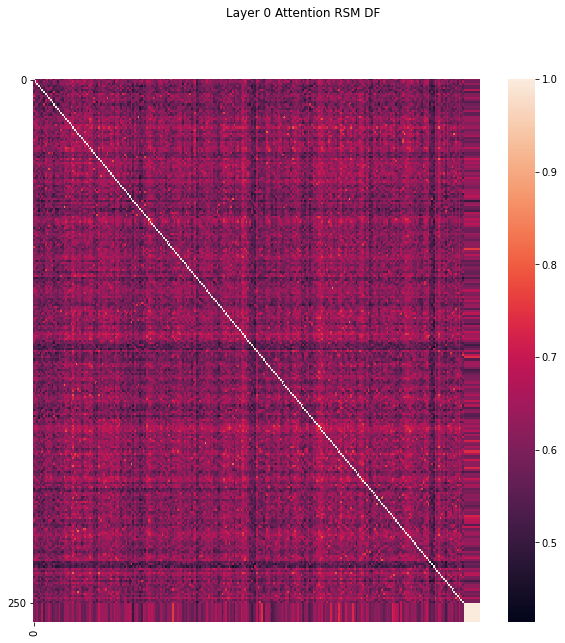

In [252]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(attention_rsm_dfs[0])

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("Layer 0 Attention RSM DF");

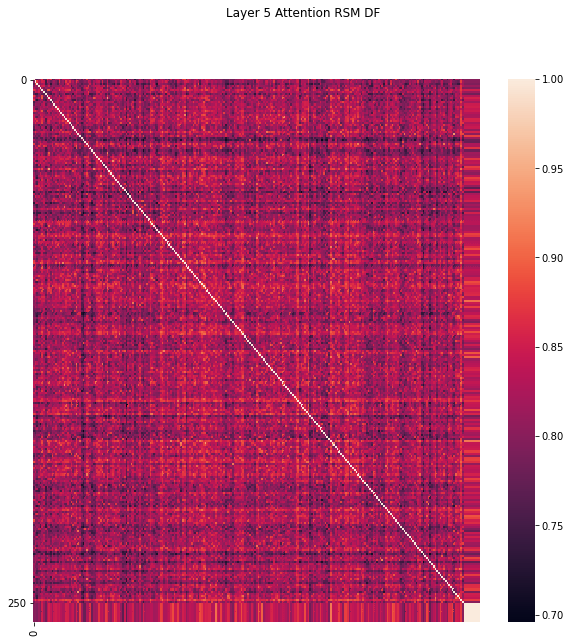

In [249]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(attention_rsm_dfs[5])

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("Layer 5 Attention RSM DF");

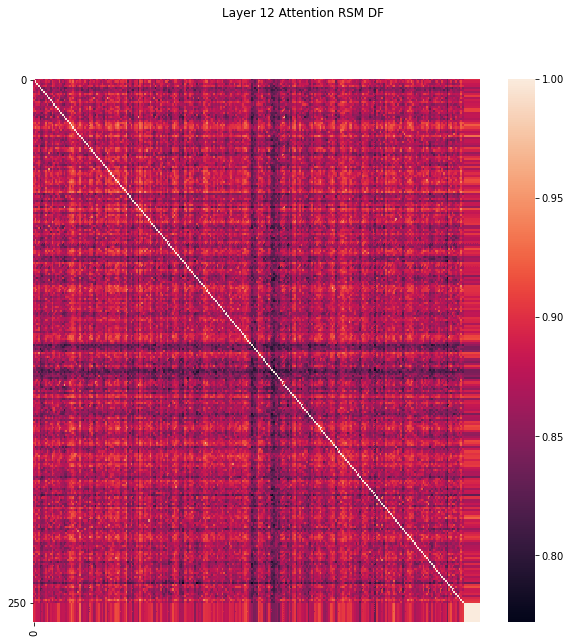

In [255]:
for layer in len(attention_rsm_dfs):
    
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(attention_rsm_dfs[2])

    ax.set_xticks(ax.get_xticks()[::50])
    ax.set_yticks(ax.get_yticks()[::50])

    plt.suptitle("Layer 12 Attention RSM DF");